In [39]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
# Load dataset
df = pd.read_csv('process_dataset.csv')

print(" Dataset Loaded Successfully")
print(df.head())



 Dataset Loaded Successfully
   cat__Type of Travel_Personal Travel  cat__Class_Eco  remainder__id  \
0                                  0.0             0.0        90035.0   
1                                  0.0             1.0        12360.0   
2                                  0.0             0.0        77959.0   
3                                  0.0             1.0        39177.0   
4                                  0.0             1.0        27508.0   

   remainder__Flight Distance  remainder__Inflight wifi service  \
0                      2863.0                               1.0   
1                       192.0                               2.0   
2                      3377.0                               0.0   
3                       311.0                               3.0   
4                       556.0                               5.0   

   remainder__Ease of Online booking  remainder__Online boarding  \
0                                3.0                         

In [41]:
# Separate features (X) and target (y)
X = df.drop('remainder__satisfaction_encoded', axis=1)
y = df['remainder__satisfaction_encoded']

In [42]:
# Train-Test Split (80-20) with stratified sampling for balance
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [43]:
# Feature Scaling (important for LR & distance-based models)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
#  Default Logistic Regression
# ------------------------------------------------------------

print(" DEFAULT LOGISTIC REGRESSION")


default_model = LogisticRegression(max_iter=1000, random_state=42)
default_model.fit(X_train_scaled, y_train)
y_pred_default = default_model.predict(X_test_scaled)
y_proba_default = default_model.predict_proba(X_test_scaled)[:, 1]

# Evaluation Metrics
acc_d = accuracy_score(y_test, y_pred_default)
f1_d = f1_score(y_test, y_pred_default)
prec_d = precision_score(y_test, y_pred_default)
recall_d = recall_score(y_test, y_pred_default)
auc_d = roc_auc_score(y_test, y_proba_default)

print(f"Accuracy  : {acc_d:.4f}")
print(f"F1 Score  : {f1_d:.4f}")
print(f"Precision : {prec_d:.4f}")
print(f"Recall    : {recall_d:.4f}")
print(f"AUC       : {auc_d:.4f}")

 DEFAULT LOGISTIC REGRESSION
Accuracy  : 0.8525
F1 Score  : 0.8360
Precision : 0.8478
Recall    : 0.8246
AUC       : 0.9124


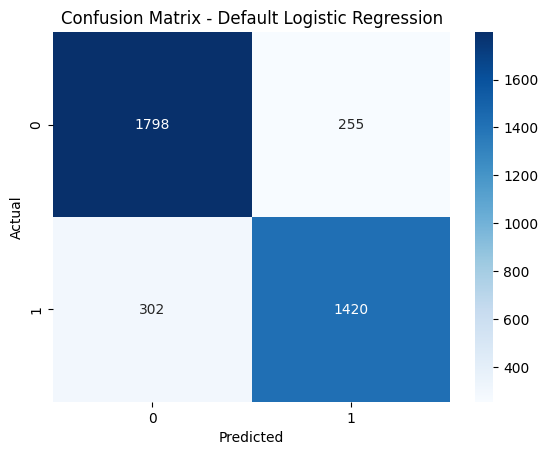

In [45]:
# Confusion Matrix
cm_default = confusion_matrix(y_test, y_pred_default)
sns.heatmap(cm_default, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Default Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [46]:
# Manual Parameter Tuning
# ------------------------------------------------------------

print("MODEL 2: MANUAL PARAMETER TUNING")


# We’ll test 3 manual configurations (varieties)
manual_params = [
    {'solver': 'liblinear', 'penalty': 'l2', 'C': 1},
    {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1},
    {'solver': 'saga', 'penalty': 'l1', 'C': 0.1}
]

results_manual = []

for params in manual_params:
    model = LogisticRegression(max_iter=1000, random_state=42, **params)
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)

    results_manual.append({
        'Parameters': params,
        'Accuracy': acc,
        'F1 Score': f1,
        'Precision': prec,
        'Recall': rec,
        'AUC': auc
    })


manual_df = pd.DataFrame(results_manual)
print("\nManual Tuning Results:")
print(manual_df)


MODEL 2: MANUAL PARAMETER TUNING

Manual Tuning Results:
                                         Parameters  Accuracy  F1 Score  \
0  {'solver': 'liblinear', 'penalty': 'l2', 'C': 1}  0.852450  0.836032   
1    {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.1}  0.852450  0.836032   
2     {'solver': 'saga', 'penalty': 'l1', 'C': 0.1}  0.852715  0.836374   

   Precision    Recall       AUC  
0   0.847761  0.824623  0.912456  
1   0.847761  0.824623  0.912476  
2   0.847852  0.825203  0.912474  


In [47]:
# Pick best manual model
best_manual = results_manual[np.argmax([r['Accuracy'] for r in results_manual])]
print("\n Best Manual Parameters:", best_manual['Parameters'])


 Best Manual Parameters: {'solver': 'saga', 'penalty': 'l1', 'C': 0.1}


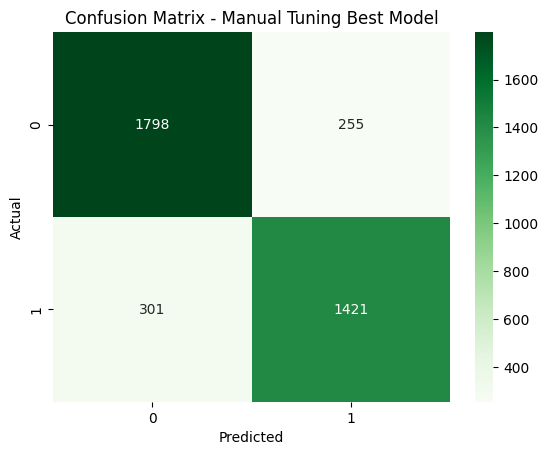

In [48]:
# Confusion Matrix for Best Manual Model
best_manual_model = LogisticRegression(max_iter=1000, random_state=42, **best_manual['Parameters'])
best_manual_model.fit(X_train_scaled, y_train)
y_pred_manual = best_manual_model.predict(X_test_scaled)

cm_manual = confusion_matrix(y_test, y_pred_manual)
sns.heatmap(cm_manual, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - Manual Tuning Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [49]:
# GridSearchCV (Automated Hyperparameter Tuning)

print(" GRIDSEARCHCV TUNING")


param_grid = [
    {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1]},
    {'solver': ['lbfgs'], 'penalty': ['l2'], 'C': [0.01, 0.1, 1]},
    {'solver': ['saga'], 'penalty': ['l1', 'l2'], 'C': [0.01, 0.1, 1]}
]

grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    n_jobs=-1
)
grid_search.fit(X_train_scaled, y_train)

print("\n Best Parameters (GridSearchCV):", grid_search.best_params_)
print(f" Best CV Accuracy: {grid_search.best_score_:.4f}")

 GRIDSEARCHCV TUNING

 Best Parameters (GridSearchCV): {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
 Best CV Accuracy: 0.8466



GridSearchCV Evaluation:
Accuracy  : 0.8525
F1 Score  : 0.8361
Precision : 0.8473
Recall    : 0.8252
AUC       : 0.9125


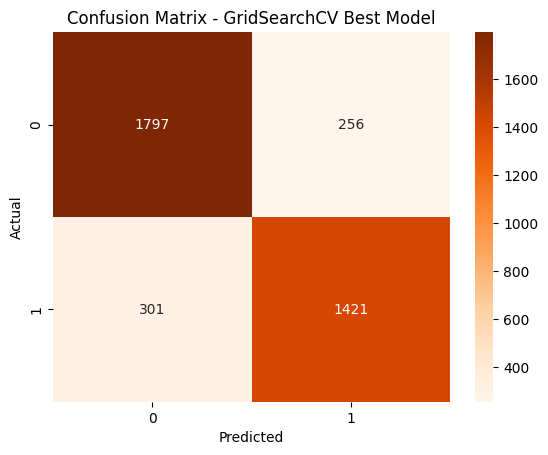

In [50]:
# Evaluate on test data
best_grid_model = grid_search.best_estimator_
y_pred_grid = best_grid_model.predict(X_test_scaled)
y_proba_grid = best_grid_model.predict_proba(X_test_scaled)[:, 1]

acc_g = accuracy_score(y_test, y_pred_grid)
f1_g = f1_score(y_test, y_pred_grid)
prec_g = precision_score(y_test, y_pred_grid)
recall_g = recall_score(y_test, y_pred_grid)
auc_g = roc_auc_score(y_test, y_proba_grid)

print("\nGridSearchCV Evaluation:")
print(f"Accuracy  : {acc_g:.4f}")
print(f"F1 Score  : {f1_g:.4f}")
print(f"Precision : {prec_g:.4f}")
print(f"Recall    : {recall_g:.4f}")
print(f"AUC       : {auc_g:.4f}")

cm_grid = confusion_matrix(y_test, y_pred_grid)
sns.heatmap(cm_grid, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix - GridSearchCV Best Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

 MODEL COMPARISON TABLE
          Model  Accuracy  F1 Score  Precision    Recall       AUC
0       Default  0.852450  0.836032   0.847761  0.824623  0.912448
1   Best Manual  0.852715  0.836374   0.847852  0.825203  0.912474
2  GridSearchCV  0.852450  0.836128   0.847346  0.825203  0.912467


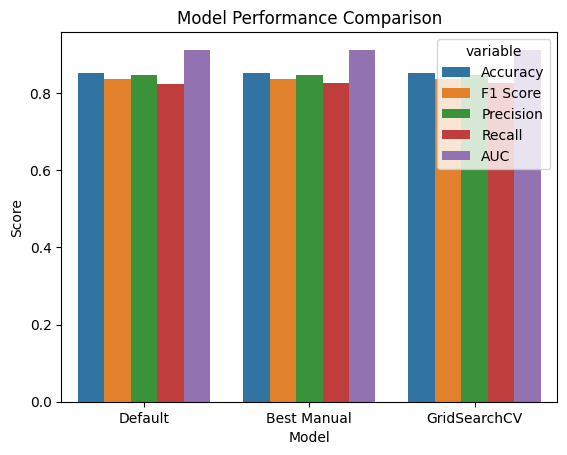

In [51]:
#  Model Comparison Table

comparison = pd.DataFrame({
    'Model': ['Default', 'Best Manual', 'GridSearchCV'],
    'Accuracy': [acc_d, best_manual['Accuracy'], acc_g],
    'F1 Score': [f1_d, best_manual['F1 Score'], f1_g],
    'Precision': [prec_d, best_manual['Precision'], prec_g],
    'Recall': [recall_d, best_manual['Recall'], recall_g],
    'AUC': [auc_d, best_manual['AUC'], auc_g]
})

print(" MODEL COMPARISON TABLE")
print(comparison)

sns.barplot(data=comparison.melt(id_vars='Model'), x='Model', y='value', hue='variable')
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.show()